# Reading image files 

In [1]:
SEED=42

In [2]:
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

In [3]:
TRAINING_CSV_PATH = '../data/raw/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30 
IMAGE_HEIGHT = IMAGE_WIDTH

In [4]:
os.path.dirname(TRAINING_CSV_PATH)

'../data/raw/Final_Training/Images/*'

In [5]:
def build_images_database(path):
    """Build a pandas Dataframe with all images information.
    
    Parameters 
    ----------
    path: path pattern to read csv files containing images information 
    
    Return 
    ------
    A pandas DataFrame with one line per image 
    """
    
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
        
    return pd.concat(df_list, ignore_index=True)



def build_images_list(filename_list):
    """Build a list of images as np.array
    
    
    Parameters
    -------
    filename_list : list of images filenames
   
    
    Returns 
    ------
    An list of np.array images
    
    """
    
    images_list = []
    for filename in filename_list:
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        image = image.getdata(band=0)
        image = np.array(image)
        images_list.append(image)
        
    return images_list



def build_classes_array(df, col_name="ClassId"):
    """" Build a vector numpy array of classes
    
    Parameters 
    ---------
    df : pd DataFrame with a column containing classes id
    
    Returns 
    ----------
    
    """
    return df[col_name].values
    

In [6]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,38,35,5,5,33,30,31,../data/raw/Final_Training/Images/00031/00000_...
1,00000_00001.ppm,40,36,6,5,34,31,31,../data/raw/Final_Training/Images/00031/00000_...
2,00000_00002.ppm,40,37,5,5,34,32,31,../data/raw/Final_Training/Images/00031/00000_...
3,00000_00003.ppm,41,39,6,6,36,34,31,../data/raw/Final_Training/Images/00031/00000_...
4,00000_00004.ppm,43,37,6,5,38,32,31,../data/raw/Final_Training/Images/00031/00000_...


In [7]:
images_df["Width"].value_counts()

34     1327
35     1323
31     1319
33     1316
30     1304
       ... 
243       1
218       1
183       1
184       1
220       1
Name: Width, Length: 187, dtype: int64

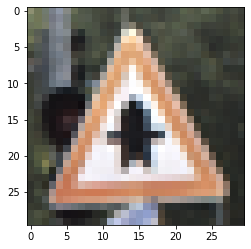

In [8]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

In [9]:
images_list = build_images_list(images_df['path'])

In [10]:
images_list[1].shape

(900,)

## Training the model

In [11]:
from sklearn import svm, metrics, datasets

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

### Take a sample for the code

In [12]:
images_df.shape

(39209, 9)

In [13]:
N = None

if N is None:
    
    images_list = build_images_list(images_df['path'].values)
                                
    data = np.array(images_list)
    labels = build_classes_array(images_df)

else : 
    images_list = build_images_list(images_df.head(N)['path'].values)
    
    data = np.array(images_list)
    labels = build_classes_array(images_df)[:N]


print(data.shape, labels.shape)

(39209, 900) (39209,)


In [14]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=SEED)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 900) (7842, 900) (31367,) (7842,)


In [16]:
#after several tests in Google collab : optimal parameters :

param_grid = [
  {'C': [10], 'kernel': ['rbf']},
 ]
svc = svm.SVC(random_state=SEED)
clf = GridSearchCV(svc, param_grid)
model = clf.fit(X_train, y_train)

### Prediction & Score model

In [17]:
# prédire sur le jeu de test
y_pred = clf.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.9491201224177506


In [18]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = y_test
accuracy_df['predicted']= y_pred

<AxesSubplot:xlabel='predicted', ylabel='actual'>

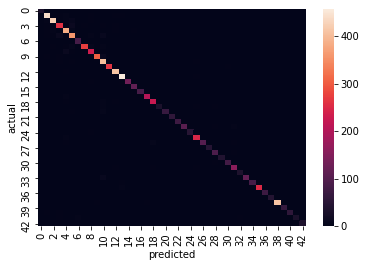

In [19]:
import seaborn as sns

sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted']))

## Save the classifier 

In [22]:
import pickle 

from joblib import dump, load

In [23]:
s = pickle.dumps(clf)
dump(clf, '../models/SVM-traffic.joblib') 

['../models/SVM-traffic.joblib']

## Testing model

In [24]:
def classify_image(path, model):
    """Classify image by model
  
  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier
  
  Returns
  -------
  class id returned by model classifier
  """
    images_list = []
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)) 
    image = image.getdata(band=0)
    image = np.array(image)
    images_list.append(image)
    
    return clf.predict(np.array(images_list))

In [25]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
classify_image(image_sample['path'].values[0], clf.predict)

array([25])

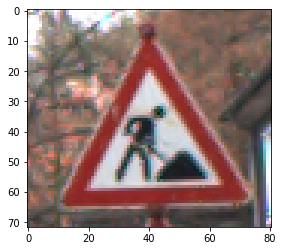

In [26]:
# Affichage de l'image
plt.imshow(Image.open(image_sample['path'].values[0]))

## Reloading model

In [27]:
test_model = load('../models/SVM-traffic.joblib') 

In [28]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
classify_image(image_sample['path'].values[0],
               test_model)

array([37])

## Evaluating performance

### Load test data

In [29]:
test_images_df = pd.read_csv('../data/raw/GT-final_test.csv', sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x:'../data/raw/Final_Test/Images/' + x) 
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,../data/raw/Final_Test/Images/12625.ppm
12626,12626.ppm,50,51,6,5,45,46,33,../data/raw/Final_Test/Images/12626.ppm
12627,12627.ppm,29,29,6,6,24,24,6,../data/raw/Final_Test/Images/12627.ppm
12628,12628.ppm,48,49,5,6,43,44,7,../data/raw/Final_Test/Images/12628.ppm
12629,12629.ppm,32,31,6,5,27,26,10,../data/raw/Final_Test/Images/12629.ppm


In [30]:
test_list = build_images_list(test_images_df['path'].values)

test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)

In [31]:
print(test_data.shape, test_labels.shape)

(12630, 900) (12630,)


In [32]:
# prédire sur le jeu de données Test : 
y_pred_test = test_model.predict(test_data)

In [33]:
test_labels[:3]

array([16,  1, 38])

In [34]:
test_labels == y_pred_test

array([ True,  True,  True, ..., False, False,  True])

In [35]:
np.transpose(y_pred_test)

array([16,  1, 38, ...,  3,  3, 10])

### Compare actual to predicted

In [36]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels 
accuracy_df['predicted']= y_pred_test

In [37]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


<AxesSubplot:xlabel='predicted', ylabel='actual'>

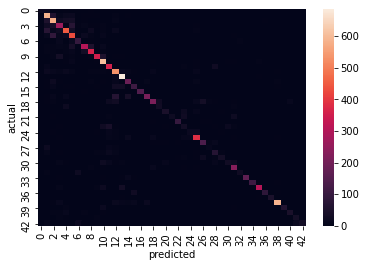

In [38]:
import seaborn as sns

sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted']))

In [39]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'])

predicted,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
actual,,,,,,,,,,,,,,,,,,,,,
0,24,24,2,2,3,0,0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
1,4,587,57,9,17,20,0,4,5,4,...,0,0,0,0,0,0,0,0,0,0
2,0,54,577,25,34,35,0,3,0,1,...,0,0,0,4,0,0,0,1,0,0
3,2,27,40,265,6,71,3,10,3,3,...,2,0,0,0,0,2,0,0,0,0
4,0,71,16,26,452,34,0,1,24,0,...,0,0,1,0,0,1,0,0,0,0
5,0,16,90,15,24,432,0,19,7,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,2,14,1,18,96,0,5,0,...,0,0,0,0,0,0,0,0,0,1
7,0,6,8,10,7,39,0,306,53,0,...,0,0,0,0,0,0,0,0,0,0
8,0,6,7,5,8,13,0,34,362,0,...,0,0,1,0,0,0,0,2,0,0


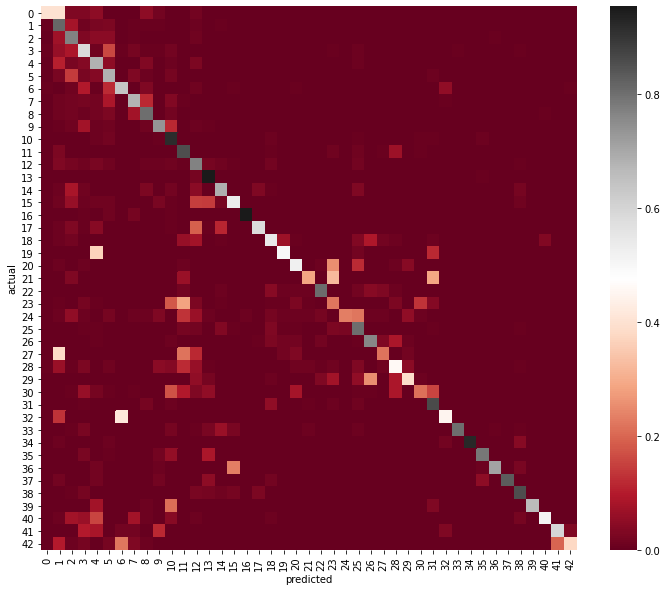

In [40]:
import seaborn as sns

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'],normalize="index"), 
            cmap="RdGy",
            ax = ax);

### Report

In [41]:
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(test_labels, y_pred_test)))

Classification report for - 
GridSearchCV(estimator=SVC(random_state=42),
             param_grid=[{'C': [10], 'kernel': ['rbf']}]):
              precision    recall  f1-score   support

           0       0.75      0.40      0.52        60
           1       0.65      0.82      0.73       720
           2       0.64      0.77      0.70       750
           3       0.54      0.59      0.56       450
           4       0.68      0.68      0.68       660
           5       0.61      0.69      0.65       630
           6       0.66      0.64      0.65       150
           7       0.77      0.68      0.72       450
           8       0.73      0.80      0.77       450
           9       0.87      0.74      0.80       480
          10       0.72      0.92      0.81       660
          11       0.71      0.85      0.77       420
          12       0.66      0.77      0.71       690
          13       0.85      0.95      0.90       720
          14       0.64      0.69      0.66       270
  

On constate que l'accuracy de ce modèle (SVM) est plus faible que le neural network. 
- L'accuracy de la base train, du validation set du neural network est égal à 0,98 contre 0,94 pour le SVM modèle
- De plus, on trouve une accuracy de 0,73 pour la base test pour le SVM, tandis que pour le neural network on trouve une accuracy de 0,96 pour le neural network. 

Concernant les erreurs de classification, on remarque que :
##### Le neural network classe mal : 
- la classe 3 (24 mauvaises classification) : qui correspond aux panneaux 'Speed limit (60km/h)', le neural network les confond avec les panneaux 'Speed limit (80km/h)'
- la classe 12 (40 mauvaises classification), qui sont les panneaux 'Priority road', confondus avec 'No vehicles'
- la classe 30 (30 mauvaises classification), qui sont les panneaux 'Beware of ice/snow', confondus avec 'Slippery road'

##### Le SVM classe mal (moins de la moitié) :
- la classe 23,'Slippery road' confondu avec la 9, la 10 ("No passing', "No passing veh over 3.5 tons') 
- la classe 19,'Dangerous curve left', majoritairement confondu avec la classe 4 ('Speed limit (70km/h)') 
- la classe 32,''End speed + passing limits', majoritairement confondu avec la classe 6 ('End of speed limit (80km/h)') 
- la classe 28 
- la classe 27, etc.. 

#### On voit très bien, que le neural network est pour cette classification, beaucoup plus performant que le modèle SVM. 